# Predict Model

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import re
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,5
from scipy import stats as st
import seaborn as sns

In [2]:
df = pd.read_csv('Video_Games_Sales/Video_Games_Sales_as_at_22_Dec_2016.csv')
df = df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales',\
         'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']].copy()
df['Year_of_Release'] = df.Year_of_Release.astype('Int64')
df.rename(columns = {df.columns[2]: 'Year'}, inplace = True)
df['User_Score'].replace('tbd', np.NaN, inplace=True)
df['User_Score'] = df.User_Score.astype('Float64')
df['User_Count'] = df.User_Count.astype('Int64')
df['Critic_Count'] = df.Critic_Count.astype('Int64')
df['User_Score'] = df['User_Score'] * 10
df.drop(index=14246, axis=0, inplace=True)
df.Name.fillna(df.groupby(['Publisher', 'Year']).Name.transform('first'), inplace=True)
df.Genre.fillna(df.groupby(['Publisher', 'Year', 'Name']).Genre.transform('first'), inplace=True)
df['Year'].fillna(df['Name'].apply(lambda x: re.findall(r'\d{4}', x))\
                            .map(lambda x: int(x[0]) if len(x) != 0 else None).astype('Int64'), inplace=True)
df['Year'].fillna(df.groupby(['Name', 'Publisher'])['Year'].transform('min'), inplace=True)
df['Year'].fillna(df.groupby(['Name', 'Developer'])['Year'].transform('min'), inplace=True)
df['Year'].fillna(df.groupby(['Name'])['Year'].transform('min'), inplace=True)
df['Year'].fillna(df.groupby(['Platform', 'Publisher'])['Year'].transform('min'), inplace=True)
df['Year'].fillna(df.groupby(['Platform', 'Developer'])['Year'].transform('min'), inplace=True)
df['Year'].fillna(df.groupby(['Platform'])['Year'].transform('min'), inplace=True)
df['Publisher'] = df['Publisher'].apply(lambda x: np.NaN if x == 'Unknown' else x)
display(df.Year.isna().sum())
display(df.Publisher.isna().sum())

0

255

In [3]:
pabl_devs_names = df.groupby('Name').agg(
    num_platf=('Platform', 'nunique'), # количество платформ
    count_platf=('Platform', 'count'), # количество изданий (т.е. для одной платформы могло издаваться несколько версий игры)
    num_publ=('Publisher', 'nunique'), # количество уникальных издателей
    count_publ=('Publisher', 'count'), # общее количество издателей
    size_publ=('Publisher', 'size'), # общее количество издателей с NaN
    num_devs=('Developer', 'nunique'), # количество уникальных разработчиков
    count_devs=('Developer', 'count'), # общее количество разработчиков
    size_devs=('Developer', 'size'), # общее количество разработчиков с NaN
    first_year=('Year', 'min'), # год первого издания (-й)
    last_year=('Year', 'max'), # последнего издания (-й)
    num_year=('Year', 'nunique'), # количество уникальных значений года (период времени релизов, в годах)
    count_year=('Year', 'count')).sort_values('num_publ', ascending=False).reset_index()
pabl_devs_names.loc[:, 'publ_isna'] = pabl_devs_names.size_publ - pabl_devs_names.count_publ
pabl_devs_names.loc[:, 'devs_isna'] = pabl_devs_names.size_devs - pabl_devs_names.count_devs
pabl_devs_names = pabl_devs_names[['Name', 'num_platf', 'count_platf', 'num_publ', 'count_publ', 'publ_isna', 'num_devs',\
                                   'count_devs', 'devs_isna', 'first_year', 'last_year', 'num_year', 'count_year']]
pabl_devs_names.sort_values(by=['devs_isna', 'num_platf'], ascending=False).head(5)

,Name,num_platf,count_platf,num_publ,count_publ,publ_isna,num_devs,count_devs,devs_isna,first_year,last_year,num_year,count_year
5136,The Amazing Spider-Man 2 (2014),7,7,1,7,0,0,0,7,2014,2014,1,7
6746,FIFA 12,7,7,1,7,0,0,0,7,2011,2011,1,7
9,Minecraft,6,6,3,6,0,0,0,6,2013,2016,3,6
16,The Walking Dead: Season One,6,6,3,6,0,0,0,6,2012,2014,3,6
3139,"Transformers: Revenge of the Fallen (XBox 360,...",6,6,1,6,0,0,0,6,2009,2009,1,6


In [4]:
display(df.Publisher.isna().sum())
display(df.Developer.isna().sum())
df['Developer'].fillna(df['Publisher'], inplace=True)
df['Publisher'].fillna(df['Developer'], inplace=True)
df.drop(df[(df.Publisher.isna()) & (df.Global_Sales < 0.1)].index, inplace=True)
df.loc[(df.Name.str.contains('Game Boy Advance Video')) | (df.Name.str.contains('Gameboy Advance Video')), 'Publisher'] = 'Nintendo'
df.loc[(df.Name.str.contains('Game Boy Advance Video')) | (df.Name.str.contains('Gameboy Advance Video')), 'Developer'] = 'Nintendo'
df.loc[df.Name == 'wwe Smackdown vs. Raw 2006', 'Publisher'] = 'THQ'
df.loc[df.Name == 'wwe Smackdown vs. Raw 2006', 'Developer'] = "Yuke's"
df.loc[df.Name == 'Gran Turismo Concept 2001 Tokyo', 'Publisher'] = 'Sony Interactive Entertainment'
df.loc[df.Name == 'Gran Turismo Concept 2001 Tokyo', 'Developer'] = 'Polyphony Digital'
df.loc[df.Name == 'Triple Play 99', 'Publisher'] = 'Electronic Arts'
df.loc[df.Name == 'Triple Play 99', 'Developer'] = 'EA Sport'
df.loc[df.Name == 'God Eater', 'Publisher'] = 'Bandai Namco Entertainment'
df.loc[df.Name == 'God Eater', 'Developer'] = 'Bandai Namco Studio'
df.loc[df.Name == 'Rhythm Heaven', 'Publisher'] = 'Nintendo'
df.loc[df.Name == 'Rhythm Heaven', 'Developer'] = 'Nintendo'
df.loc[df.Name == "Bentley's Hackpack", 'Publisher'] = 'Sony Computer Entertainment'
df.loc[df.Name == "Bentley's Hackpack", 'Developer'] = 'Sanzaru Games'
df.loc[df.Name == 'The Game of Life', 'Publisher'] = 'Marmalade Game Studio Ltd'
df.loc[df.Name == 'The Game of Life', 'Developer'] = 'Marmalade Game Studio Ltd'
df.loc[df.Name == 'WarioWare: Twisted!', 'Publisher'] = 'Nintendo'
df.loc[df.Name == 'WarioWare: Twisted!', 'Developer'] = 'Nintendo'
df.drop(df[(df.Publisher.isna()) & (df.Developer.isna())].index, inplace=True)
display(df.Publisher.isna().sum())
display(df.Developer.isna().sum())

255

6622

0

0

In [5]:
df.loc[df.Platform.isin(['PS', 'PS2', 'PS3', 'PS4', 'PSV', 'PSP']), 'Platform_Producer'] = 'Sony'
df.loc[df.Platform.isin(['X360', 'XB', 'XOne']), 'Platform_Producer'] = 'Microsoft'
df.loc[df.Platform.isin(['Wii', 'N64', 'SNES', 'NES', 'GC', 'DS', 'WiiU', '3DS', 'GB', 'GBA']), 'Platform_Producer'] = 'Nintendo'
df.loc[df.Platform.isin(['GEN', 'SCD', 'SAT', 'GG', 'DC']), 'Platform_Producer'] = 'Sega'
df.loc[df.Platform.isin(['PCFX', 'TG16']), 'Platform_Producer'] = 'NEC'
df.loc[df.Platform == '3DO', 'Platform_Producer'] = 'Panasonic'
df.loc[df.Platform == 'NG', 'Platform_Producer'] = 'SNK'
df.loc[df.Platform == 'WS', 'Platform_Producer'] = 'Bandai'
df.loc[df.Platform == '2600', 'Platform_Producer'] = 'Atari'
df.loc[df.Platform == 'PC', 'Platform_Producer'] = 'PC'
df.loc[df.Platform.isin(['PS', 'PS2', 'PS3', 'PS4', 'X360', 'XB', 'XOne', 'Wii', 'N64', 'SNES', 'NES', 'GS', 'GEN', 'SCD',\
                         'SAT', '3DO', 'GC', 'DC', 'NG', 'TG16', 'PCFX', '2600']), 'Platform_Type'] = 'TV Console'
df.loc[df.Platform.isin(['PSP', 'PSV', 'DS', 'WiiU', '3DS', 'GB', 'GBA', 'GG', 'WS']), 'Platform_Type'] = 'Portable'
df.loc[df.Platform == 'PC', 'Platform_Type'] = 'PC'

sales = df[['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Developer', 'Platform_Producer', 'Platform_Type',\
            'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].copy()
sales.head()

,Name,Platform,Year,Genre,Publisher,Developer,Platform_Producer,Platform_Type,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,Nintendo,Nintendo,TV Console,82.53,41.36,28.96,3.77,8.45
1,Super Mario Bros.,NES,1985,Platform,Nintendo,Nintendo,Nintendo,TV Console,40.24,29.08,3.58,6.81,0.77
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,Nintendo,Nintendo,TV Console,35.52,15.68,12.76,3.79,3.29
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,Nintendo,Nintendo,TV Console,32.77,15.61,10.93,3.28,2.95
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,Nintendo,Nintendo,Portable,31.37,11.27,8.89,10.22,1.00


In [6]:
sales_by_years = sales.groupby('Year')['Global_Sales'].sum().reset_index().iloc[:38]
sales_by_years

,Year,Global_Sales
0,1980,19.36
1,1981,35.48
2,1982,28.86
3,1983,16.79
4,1984,50.36
5,1985,53.96
6,1986,37.07
7,1987,21.74
8,1988,47.22
9,1989,74.48


In [7]:
sales_by_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          38 non-null     int64  
 1   Global_Sales  38 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 736.0 bytes


In [8]:
sales_by_years.describe()

,Year,Global_Sales
count,38.000000,38.000000
mean,1998.500000,234.563684
std,11.113055,210.605138
min,1980.000000,0.060000
25%,1989.250000,48.625000
50%,1998.500000,202.135000
75%,2007.750000,361.552500
max,2017.000000,684.670000


In [9]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
X=sales_by_years[['Year']]
y=sales_by_years['Global_Sales']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)  # метод обучается на данных и подбирает оптимальные коэффициенты

LinearRegression()

In [13]:
model.coef_

array([12.47373945])

In [14]:
model.intercept_

-24700.358353986696

In [15]:
y_pred = model.predict(X_test)
y_pred

array([409.27916651, 446.70038488,  47.54072235, 159.80437744,
       371.85794815, 321.96299034,  72.48820126, 334.43672979,
       297.01551143, 184.75185635])

In [16]:
# сравним наши прогнозы с фактом
res_df = X_test.copy()

res_df['y_pred'] = y_pred
res_df['y_test'] = y_test
res_df

,Year,y_pred,y_test
33,2013,409.279167,361.82
36,2016,446.700385,129.99
4,1984,47.540722,50.36
13,1993,159.804377,48.37
30,2010,371.857948,594.61
26,2006,321.962990,532.17
6,1986,72.488201,37.07
27,2007,334.436730,608.13
24,2004,297.015511,429.05
15,1995,184.751856,88.11


In [17]:
# значение коэффициента детерминации
model.score(X_test, y_test)

0.4042434642182716

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
mean_squared_error(y_train, model.predict(X_train), squared=False)

141.6909084946537

In [20]:
mean_squared_error(y_test, model.predict(X_test), squared=False)

176.55709625981922

In [21]:
predict_df = pd.DataFrame({'Year': [2018, 2019, 2020, 2021, 2022, 2023]})
predict_df

,Year
0,2018
1,2019
2,2020
3,2021
4,2022
5,2023


In [22]:
sales_predict = model.predict(predict_df)
sales_predict

array([471.64786378, 484.12160324, 496.59534269, 509.06908214,
       521.5428216 , 534.01656105])

In [23]:
sales_predict_df = pd.DataFrame({'Year': [2018, 2019, 2020, 2021, 2022, 2023], 'Global_Sales': sales_predict})
sales_predict_df['Global_Sales'] = round(sales_predict_df.Global_Sales, 2)
sales_predict_df

,Year,Global_Sales
0,2018,471.65
1,2019,484.12
2,2020,496.60
3,2021,509.07
4,2022,521.54
5,2023,534.02


In [24]:
full_df = pd.concat([sales_by_years, sales_predict_df])
full_df.reset_index().drop(columns='index')

,Year,Global_Sales
0,1980,19.36
1,1981,35.48
2,1982,28.86
3,1983,16.79
4,1984,50.36
5,1985,53.96
6,1986,37.07
7,1987,21.74
8,1988,47.22
9,1989,74.48


Text(2023, 500, ' 2023г.')

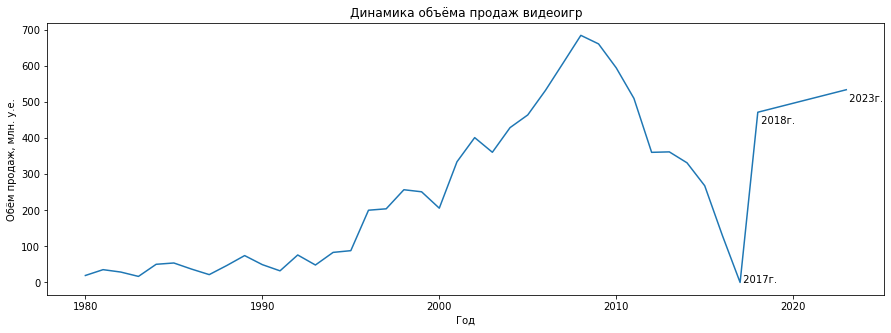

In [25]:
full_df.groupby('Year')['Global_Sales'].sum().plot(title='Динамика объёма продаж видеоигр', 
                                                   xlabel='Год', ylabel='Обём продаж, млн. у.е.')
plt.text(2017, 0.06, ' 2017г.')
plt.text(2018, 440, ' 2018г.')
plt.text(2023, 500, ' 2023г.')